In [16]:
#Essential to have this equal to scaling during training.
RNN_INPUTS_SCALING_FACTOR = 1
SIGMA_TEMP = 0.01
NUM_MIXTURES = 5

In [2]:
import keras
import tensorflow as tf

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

#Importing the VAE and RNN.
import os
import sys
#Adding WorldModels path to pythonpath
nb_dir = os.path.split(os.getcwd())[0]
print(nb_dir)
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

Using TensorFlow backend.


/home/kaiolae/code/word_models_keras_test/WorldModels


In [3]:
#To access gym
import sys
sys.path.append('/home/kaiolae/.virtualenvs/worldmodels/lib/python3.5/site-packages')
import os

In [4]:

import analyze_rnn_predictions
%load_ext autoreload
%autoreload 2 #If we want to automatically load external modules as they are updated.

/home/kaiolae/code/word_models_keras_test/WorldModels


In [5]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, HTML


def plot_movie_mp4(image_array):
    dpi = 2.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    #fig = plt.figure(figsize=(1,1), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    display(HTML(anim.to_html5_video()))

In [17]:
loading_model_path = "../nov26_135_mixtures_early_stop_skip3/trained_sequential_rnn_5mixtures_run4/rnn_trained_model.h5"
NUM_MIXTURES = 5
rnn_analyzer = analyze_rnn_predictions.RNNAnalyzer(loading_model_path, NUM_MIXTURES, 1.0, io_scaling = RNN_INPUTS_SCALING_FACTOR)

VAE init
Shape before flattening: (None, 16, 16, 32)
KL Shape: (None,)
Xent shape: ()
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 3)    39          encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 32)   416         conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 16, 16, 32)   4128        conv2d_6[0][0]                   
_______________________

In [18]:
#Get a start video
#Getting data to feed into the VAE and RNN
import numpy as np
import os
# load preprocessed data
training_data = np.load(os.path.join("../rnn_data_64_dim", "rnn_training_data.npz"))
action_data = training_data['action']
observation_data = training_data['latent']

def get_random_starting_sequence(minimal_length=100):
    rand_seq_id = random.randint(0,len(observation_data))
    rand_seq = observation_data[rand_seq_id]
    while len(rand_seq) < minimal_length:        
        rand_seq_id = random.randint(0,len(observation_data))
        rand_seq = observation_data[rand_seq_id]
    return observation_data[rand_seq_id], action_data[rand_seq_id]

In [8]:
#Decode a sequence with the VAE and visualize it
def decode_and_visualize(latent_vector_sequence, rnn_analyzer):
    plot_movie_mp4(rnn_analyzer.decode_with_vae(latent_vector_sequence))

### Making a dream with the trained RNN

In [9]:
import random
def generate_random_action():
    return random.uniform(-1.0,1.0)


In [10]:
rnn_analyzer._reset()
print(len(single_latent_sequence))
rnn_analyzer.warm_up_lstm(single_action_sequence[:150], single_latent_sequence[:150])
dreamed_latents = []
#TODO Rather than action 0, select random action.
dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(generate_random_action(), previous_z=single_latent_sequence[150], sigma_temp=SIGMA_TEMP)
dreamed_latents.append(dreamed_latent)

num_timesteps=100
for i in range(num_timesteps-1):
    dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(generate_random_action(), sigma_temp=SIGMA_TEMP)
    dreamed_latents.append(dreamed_latent)
decode_and_visualize(dreamed_latents, rnn_analyzer)

300


<Figure size 64x64 with 0 Axes>

## Committing to one mixture during dreaming: 0,1,2,3

In [37]:
import count_monsters_and_balls
FIREBALL_THRESHOLD = 0.5
WALL_THRESHOLD = 0.39
def count_events_in_dream(dreamed_latent_sequence, rnn_analyzer, mixture_num):
    decoded_images = rnn_analyzer.decode_with_vae(dreamed_latent_sequence)
    num_explosions = 0
    num_fireballs = 0
    num_left_walls = 0
    num_right_walls = 0
    for img_counter in range(len(decoded_images)):
        img = decoded_images[img_counter]
        is_exploding = count_monsters_and_balls.is_there_a_big_explosion(img, FIREBALL_THRESHOLD)
        is_fireball, _ = count_monsters_and_balls.count_fireballs(img, FIREBALL_THRESHOLD)
        is_left_wall = count_monsters_and_balls.is_there_a_lefthand_wall(img, WALL_THRESHOLD)
        is_right_wall = count_monsters_and_balls.is_there_a_righthand_wall(img, WALL_THRESHOLD)

        if is_exploding:
            num_explosions+=1
        elif is_fireball:
            num_fireballs+=1
        elif is_left_wall:
            num_left_walls+=1
        elif is_right_wall:
            num_right_walls+=1
            
    events_data = [{"type":"explosion", "count":num_explosions, "mixture_num":mixture_num},
                  {"type":"fireball", "count":num_fireballs, "mixture_num":mixture_num},
                  {"type":"left_wall", "count":num_left_walls, "mixture_num":mixture_num},
                  {"type":"right_wall", "count":num_right_walls, "mixture_num":mixture_num}]
    

    return events_data

In [38]:
num_independent_tests = 10
warm_up_length = 150
num_dream_timesteps=100
events_dicts=[]
for j in range(num_independent_tests):
    print("Step ", j)
    #Getting a random conditioning sequence to start the RNN.
    
    latent_sequence, action_sequence = get_random_starting_sequence(warm_up_length)
    
    for i in range(NUM_MIXTURES):
        print(i, " mixtures")
        rnn_analyzer._reset()
        rnn_analyzer.warm_up_lstm(action_sequence[:warm_up_length], latent_sequence[:warm_up_length])
        dreamed_latents = []
        dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(generate_random_action(), previous_z=latent_sequence[warm_up_length], sigma_temp=SIGMA_TEMP,force_prediction_from_mixture = i)
        dreamed_latents.append(dreamed_latent)
        for dream_step in range(num_dream_timesteps-1):
            dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(generate_random_action(), sigma_temp=SIGMA_TEMP, force_prediction_from_mixture = i)
            dreamed_latents.append(dreamed_latent)
        events_dict = count_events_in_dream(dreamed_latents,rnn_analyzer,i)
        events_dicts.extend(events_dict)


Step  0
0  mixtures
1  mixtures
2  mixtures
3  mixtures
4  mixtures
Step  1
0  mixtures
1  mixtures
2  mixtures
3  mixtures
4  mixtures
Step  2
0  mixtures
1  mixtures
2  mixtures
3  mixtures
4  mixtures
Step  3
0  mixtures
1  mixtures
2  mixtures
3  mixtures
4  mixtures
Step  4
0  mixtures
1  mixtures
2  mixtures
3  mixtures
4  mixtures
Step  5
0  mixtures
1  mixtures
2  mixtures
3  mixtures
4  mixtures
Step  6
0  mixtures
1  mixtures
2  mixtures
3  mixtures
4  mixtures
Step  7
0  mixtures
1  mixtures
2  mixtures
3  mixtures
4  mixtures
Step  8
0  mixtures
1  mixtures
2  mixtures
3  mixtures
4  mixtures
Step  9
0  mixtures
1  mixtures
2  mixtures
3  mixtures
4  mixtures


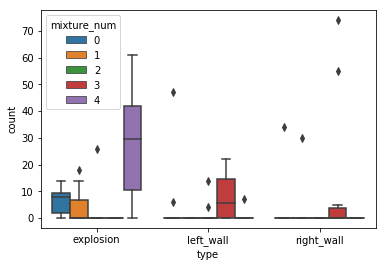

In [46]:
import pandas as pd
import seaborn as sns
#print(events_dicts)
events_frame= pd.DataFrame(events_dicts)
events_frame = events_frame[events_frame.type != "fireball"]
sns.boxplot(x="type", y="count", hue="mixture_num", data=events_frame)



In [27]:
#Committed dreaming
rnn_analyzer._reset()
print(len(single_latent_sequence))
rnn_analyzer.warm_up_lstm(single_action_sequence[:150], single_latent_sequence[:150])
dreamed_latents = []
#TODO Rather than action 0, select random action.
dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(generate_random_action(), previous_z=single_latent_sequence[150], sigma_temp=SIGMA_TEMP,force_prediction_from_mixture = 0)
dreamed_latents.append(dreamed_latent)

num_timesteps=100
for i in range(num_timesteps-1):
    dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(generate_random_action(), sigma_temp=SIGMA_TEMP, force_prediction_from_mixture = 0)
    dreamed_latents.append(dreamed_latent)
decode_and_visualize(dreamed_latents, rnn_analyzer)

300


<Figure size 64x64 with 0 Axes>

In [12]:
#Committed dreaming
rnn_analyzer._reset()
print(len(single_latent_sequence))
rnn_analyzer.warm_up_lstm(single_action_sequence[:150], single_latent_sequence[:150])
dreamed_latents = []
#TODO Rather than action 0, select random action.
dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(generate_random_action(), previous_z=single_latent_sequence[150], sigma_temp=SIGMA_TEMP,force_prediction_from_mixture = 1)
dreamed_latents.append(dreamed_latent)

num_timesteps=100
for i in range(num_timesteps-1):
    dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(generate_random_action(), sigma_temp=SIGMA_TEMP, force_prediction_from_mixture = 1)
    dreamed_latents.append(dreamed_latent)
decode_and_visualize(dreamed_latents, rnn_analyzer)

300


<Figure size 64x64 with 0 Axes>

In [15]:
#Committed dreaming
rnn_analyzer._reset()
print(len(single_latent_sequence))
rnn_analyzer.warm_up_lstm(single_action_sequence[:150], single_latent_sequence[:150])
dreamed_latents = []
#TODO Rather than action 0, select random action.
dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(generate_random_action(), previous_z=single_latent_sequence[150], sigma_temp=SIGMA_TEMP,force_prediction_from_mixture = 2)
dreamed_latents.append(dreamed_latent)

num_timesteps=300
for i in range(num_timesteps-1):
    dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(generate_random_action(), sigma_temp=SIGMA_TEMP, force_prediction_from_mixture = 2)
    dreamed_latents.append(dreamed_latent)
decode_and_visualize(dreamed_latents, rnn_analyzer)

300


<Figure size 64x64 with 0 Axes>

In [48]:
#Committed dreaming
rnn_analyzer._reset()
print(len(single_latent_sequence))
rnn_analyzer.warm_up_lstm(single_action_sequence[:150], single_latent_sequence[:150])
dreamed_latents = []
#TODO Rather than action 0, select random action.
dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(generate_random_action(), previous_z=single_latent_sequence[150], sigma_temp=SIGMA_TEMP,force_prediction_from_mixture = 4)
dreamed_latents.append(dreamed_latent)

num_timesteps=100
for i in range(num_timesteps-1):
    dreamed_latent, mixture_weights = rnn_analyzer.predict_one_step(generate_random_action(), sigma_temp=SIGMA_TEMP, force_prediction_from_mixture = 4)
    dreamed_latents.append(dreamed_latent)
decode_and_visualize(dreamed_latents, rnn_analyzer)

300


<Figure size 64x64 with 0 Axes>